<a href="https://colab.research.google.com/github/gazalpatel/REINFORCE/blob/main/week_2_trials_RL_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# ## OUTPUT FOLDER SETUP
# import os

# # Define the output folder path for saving results
# output_folder = "D:\\2.1_codebase\\0000 DL IISC CAPSTONE\\Outputs"

# # Create the folder if it doesn't already exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# print(f"Output folder set to: {output_folder}")




# Set up environment with seed
env = gym.make('CartPole-v0')
env.reset(seed=20)  # Set the seed here during reset

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold:', env.spec.reward_threshold)

# Set random seeds for reproducibility
np.random.seed(20)
torch.manual_seed(20)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
threshold: 195.0


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
import numpy as np
import torch
import gym
import itertools

# Set the hyperparameter grid
hidden_layers_options = [1, 2]
neurons_per_layer_options = [128, 256]
learning_rates_options = [0.001, 0.003, 0.005]
gamma_options = [0.95, 0.97, 0.99]

hyperparameter_grid = list(itertools.product(hidden_layers_options,
                                             neurons_per_layer_options,
                                             learning_rates_options,
                                             gamma_options))

print(f"Total configurations to test: {len(hyperparameter_grid)}")

def build_model(obs_size, n_actions, hidden_layers, neurons_per_layer):
    layers = []
    input_size = obs_size
    for i in range(hidden_layers):
        layers.append(torch.nn.Linear(input_size, neurons_per_layer))
        layers.append(torch.nn.ReLU())
        input_size = neurons_per_layer
    layers.append(torch.nn.Linear(input_size, n_actions))
    model = torch.nn.Sequential(*layers)
    return model

results = []

for config in hyperparameter_grid:
    hidden_layers, neurons_per_layer, learning_rate, gamma = config
    print(f"\nTesting configuration: hidden_layers={hidden_layers}, neurons_per_layer={neurons_per_layer}, learning_rate={learning_rate}, gamma={gamma}")

    # Set up the environment and seeding
    env = gym.make('CartPole-v0')
    seed = 20
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    # Build the model
    model = build_model(obs_size, n_actions, hidden_layers, neurons_per_layer)

    # Set the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training parameters
    Horizon = 500
    MAX_TRAJECTORIES = 500
    score = []

    for trajectory in range(MAX_TRAJECTORIES):
        curr_state = env.reset()
        done = False
        transitions = []

        for t in range(Horizon):
            # Convert curr_state to torch tensor
            curr_state_tensor = torch.from_numpy(curr_state).float()
            act_logits = model(curr_state_tensor)
            act_prob = torch.nn.functional.softmax(act_logits, dim=0)
            # Convert act_prob to numpy
            act_prob_np = act_prob.detach().numpy()
            action = np.random.choice(n_actions, p=act_prob_np)
            prev_state = curr_state
            curr_state, reward, done, info = env.step(action)
            transitions.append((prev_state, action, reward))
            if done:
                break
        score.append(len(transitions))

        # Prepare for training
        reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))

        # Compute expected returns (G_t)
        batch_Gvals = []
        for i in range(len(transitions)):
            new_Gval = 0
            power = 0
            for j in range(i, len(transitions)):
                new_Gval += (gamma ** power) * reward_batch[j].item()
                power +=1
            batch_Gvals.append(new_Gval)
        expected_returns_batch = torch.FloatTensor(batch_Gvals)
        # Normalize
        expected_returns_batch /= expected_returns_batch.max()

        state_batch = torch.Tensor([s for (s,a,r) in transitions])
        action_batch = torch.Tensor([a for (s,a,r) in transitions])

        pred_logits = model(state_batch)
        pred_batch = torch.nn.functional.softmax(pred_logits, dim=1)
        prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

        loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if trajectory % 50 == 0 and trajectory > 0:
            avg_score = np.mean(score[-50:-1])
            print(f"Trajectory {trajectory}\tAverage Score: {avg_score:.2f}")

    # Record the final average score
    final_avg_score = np.mean(score[-50:-1])
    print(f"Final Average Score: {final_avg_score:.2f}")
    results.append({
        'hidden_layers': hidden_layers,
        'neurons_per_layer': neurons_per_layer,
        'learning_rate': learning_rate,
        'gamma': gamma,
        'average_score': final_avg_score
    })


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Total configurations to test: 36

Testing configuration: hidden_layers=1, neurons_per_layer=128, learning_rate=0.001, gamma=0.95


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-2-653002147e1a>:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state_batch = torch.Tensor([s for (s,a,r) in transitions])


Trajectory 50	Average Score: 18.33
Trajectory 100	Average Score: 23.06
Trajectory 150	Average Score: 24.90
Trajectory 200	Average Score: 31.53
Trajectory 250	Average Score: 27.04
Trajectory 300	Average Score: 34.47
Trajectory 350	Average Score: 47.69
Trajectory 400	Average Score: 63.49
Trajectory 450	Average Score: 109.00
Final Average Score: 130.45

Testing configuration: hidden_layers=1, neurons_per_layer=128, learning_rate=0.001, gamma=0.97


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Trajectory 50	Average Score: 18.33
Trajectory 100	Average Score: 24.49
Trajectory 150	Average Score: 30.20
Trajectory 200	Average Score: 34.67
Trajectory 250	Average Score: 38.27
Trajectory 300	Average Score: 41.39
Trajectory 350	Average Score: 71.76
Trajectory 400	Average Score: 74.41
Trajectory 450	Average Score: 151.94
Final Average Score: 175.20

Testing configuration: hidden_layers=1, neurons_per_layer=128, learning_rate=0.001, gamma=0.99
Trajectory 50	Average Score: 18.33
Trajectory 100	Average Score: 25.65
Trajectory 150	Average Score: 30.33
Trajectory 200	Average Score: 30.98
Trajectory 250	Average Score: 30.53
Trajectory 300	Average Score: 37.10
Trajectory 350	Average Score: 51.71
Trajectory 400	Average Score: 71.88
Trajectory 450	Average Score: 126.27
Final Average Score: 147.04

Testing configuration: hidden_layers=1, neurons_per_layer=128, learning_rate=0.003, gamma=0.95
Trajectory 50	Average Score: 13.39
Trajectory 100	Average Score: 43.27
Trajectory 150	Average Score: 95.

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import gym

# Set up the environment and seeding
env = gym.make('CartPole-v0')
seed = 20
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

# Build the model
model = torch.nn.Sequential(
    torch.nn.Linear(obs_size, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, n_actions)
)

# Set the optimizer
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training parameters
Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.95
score = []

def custom_reward(obs, action):
    # Normalize cart position (-2.4 to 2.4)
    distance = 1 - abs(obs[0]) / 2.4  # Closer to center yields higher reward
    distance = max(distance, 0)  # Ensure non-negative

    # Normalize pole angle (-12° to 12°, converted to radians ~ -0.2095 to 0.2095)
    angle = 1 - abs(obs[2]) / 0.2095  # Closer to upright yields higher reward
    angle = max(angle, 0)  # Ensure non-negative

    # Penalize the use of force (actions 0 or 1)
    force = abs(action - 0.5)  # Minimal when action is 0.5

    # Compute the reward
    reward = (angle * 0.8) + (distance * 0.2) - (force * 0.004)
    reward = max(reward, 0)  # Ensure non-negative

    return reward

for trajectory in range(MAX_TRAJECTORIES):
    curr_state = env.reset()
    done = False
    transitions = []

    for t in range(Horizon):
        # Convert curr_state to torch tensor
        curr_state_tensor = torch.from_numpy(curr_state).float()
        act_logits = model(curr_state_tensor)
        act_prob = torch.nn.functional.softmax(act_logits, dim=0)
        # Convert act_prob to numpy
        act_prob_np = act_prob.detach().numpy()
        action = np.random.choice(n_actions, p=act_prob_np)
        prev_state = curr_state
        curr_state, _, done, info = env.step(action)

        # Calculate custom reward
        reward = custom_reward(curr_state, action)

        transitions.append((prev_state, action, reward))
        if done:
            break
    score.append(len(transitions))

    # Prepare for training
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))

    # Compute expected returns (G_t)
    batch_Gvals = []
    for i in range(len(transitions)):
        new_Gval = 0
        power = 0
        for j in range(i, len(transitions)):
            new_Gval += (gamma ** power) * reward_batch[j].item()
            power +=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch = torch.FloatTensor(batch_Gvals)
    # Normalize
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions])
    action_batch = torch.Tensor([a for (s,a,r) in transitions])

    pred_logits = model(state_batch)
    pred_batch = torch.nn.functional.softmax(pred_logits, dim=1)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory > 0:
        avg_score = np.mean(score[-50:-1])
        print(f"Trajectory {trajectory}\tAverage Score: {avg_score:.2f}")

print(f"\nTraining completed using the custom reward function.")


Trajectory 50	Average Score: 12.90
Trajectory 100	Average Score: 40.47
Trajectory 150	Average Score: 51.86
Trajectory 200	Average Score: 42.96
Trajectory 250	Average Score: 27.33
Trajectory 300	Average Score: 35.27
Trajectory 350	Average Score: 50.82
Trajectory 400	Average Score: 109.55
Trajectory 450	Average Score: 166.37

Training completed using the custom reward function.


In [ ]:
import numpy as np
import torch
import gym

# Function to evaluate the model
def evaluate_model(model, num_episodes=100):
    env = gym.make('CartPole-v0')
    seed = 42  # Different seed for evaluation to avoid bias
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    episode_lengths = []

    for episode in range(num_episodes):
        curr_state = env.reset()
        done = False
        t = 0

        while not done:
            curr_state_tensor = torch.from_numpy(curr_state).float()
            with torch.no_grad():  # No need to compute gradients during evaluation
                act_logits = model(curr_state_tensor)
                act_prob = torch.nn.functional.softmax(act_logits, dim=0)
            action = torch.argmax(act_prob).item()  # Choose the action with highest probability
            curr_state, _, done, _ = env.step(action)
            t += 1
            if done:
                break
        episode_lengths.append(t)

    avg_length = np.mean(episode_lengths)
    std_length = np.std(episode_lengths)
    print(f"Average Episode Length over {num_episodes} episodes: {avg_length:.2f} ± {std_length:.2f}")
    return episode_lengths

# Evaluate the model trained with custom reward function
print("Evaluating Model with Custom Reward Function:")
# 'model' should be your trained model from the previous code
episode_lengths = evaluate_model(model)


Evaluating Model with Custom Reward Function:
Average Episode Length over 100 episodes: 200.00 ± 0.00


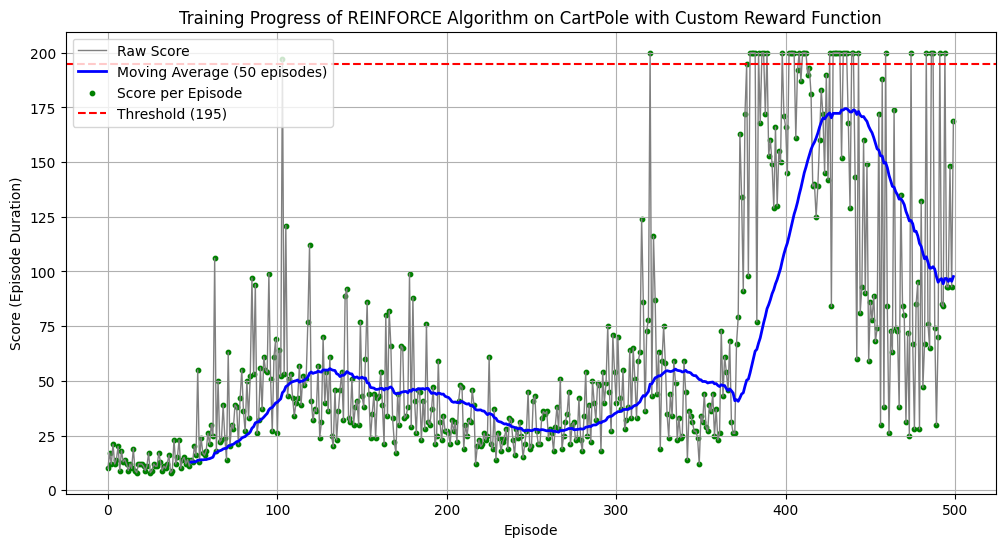

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'score' is the list of episode lengths recorded during training
# If 'score' is not available in the current scope, make sure to have it accessible

# Convert 'score' to a NumPy array for easy manipulation
score_array = np.array(score)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of REINFORCE Algorithm on CartPole with Custom Reward Function')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import torch
import gym

# Set up the environment and seeding
env = gym.make('CartPole-v0')
seed = 20
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

# Build the model with the best configuration
model_baseline = torch.nn.Sequential(
    torch.nn.Linear(obs_size, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, n_actions)
)

# Set the optimizer
learning_rate = 0.003
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=learning_rate)

# Training parameters
Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.95
score_baseline = []

for trajectory in range(MAX_TRAJECTORIES):
    curr_state = env.reset()
    done = False
    transitions = []

    for t in range(Horizon):
        # Convert curr_state to torch tensor
        curr_state_tensor = torch.from_numpy(curr_state).float()
        act_logits = model_baseline(curr_state_tensor)
        act_prob = torch.nn.functional.softmax(act_logits, dim=0)
        # Convert act_prob to numpy
        act_prob_np = act_prob.detach().numpy()
        action = np.random.choice(n_actions, p=act_prob_np)
        prev_state = curr_state
        curr_state, reward, done, info = env.step(action)

        # Use the original reward from the environment
        transitions.append((prev_state, action, reward))
        if done:
            break
    score_baseline.append(len(transitions))

    # Prepare for training
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))

    # Compute expected returns (G_t)
    batch_Gvals = []
    for i in range(len(transitions)):
        new_Gval = 0
        power = 0
        for j in range(i, len(transitions)):
            new_Gval += (gamma ** power) * reward_batch[j].item()
            power +=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch = torch.FloatTensor(batch_Gvals)
    # Normalize
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions])
    action_batch = torch.Tensor([a for (s,a,r) in transitions])

    pred_logits = model_baseline(state_batch)
    pred_batch = torch.nn.functional.softmax(pred_logits, dim=1)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory > 0:
        avg_score = np.mean(score_baseline[-50:-1])
        print(f"Trajectory {trajectory}\tAverage Score: {avg_score:.2f}")

print("\nTraining completed with the original reward function.")


Trajectory 50	Average Score: 13.39
Trajectory 100	Average Score: 43.27
Trajectory 150	Average Score: 95.39
Trajectory 200	Average Score: 122.31
Trajectory 250	Average Score: 142.00
Trajectory 300	Average Score: 165.43
Trajectory 350	Average Score: 163.04
Trajectory 400	Average Score: 176.14
Trajectory 450	Average Score: 200.00

Training completed with the original reward function.


In [ ]:
import numpy as np
import torch
import gym

# Function to evaluate a model
def evaluate_model(model, num_episodes=100):
    env = gym.make('CartPole-v0')
    seed = 42  # Different seed for evaluation to avoid bias
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    episode_lengths = []

    for episode in range(num_episodes):
        curr_state = env.reset()
        done = False
        t = 0

        while not done:
            curr_state_tensor = torch.from_numpy(curr_state).float()
            with torch.no_grad():  # No need to compute gradients during evaluation
                act_logits = model(curr_state_tensor)
                act_prob = torch.nn.functional.softmax(act_logits, dim=0)
            action = torch.argmax(act_prob).item()  # Choose the action with highest probability
            curr_state, _, done, _ = env.step(action)
            t += 1
            if done:
                break
        episode_lengths.append(t)

    avg_length = np.mean(episode_lengths)
    std_length = np.std(episode_lengths)
    print(f"Average Episode Length over {num_episodes} episodes: {avg_length:.2f} ± {std_length:.2f}")
    return episode_lengths

# Evaluate the baseline model
print("Evaluating Baseline Model (Original Reward Function):")
baseline_episode_lengths = evaluate_model(model_baseline)

# Assuming you have the custom reward model as 'model_custom'
# If you need to reload it, make sure to load it appropriately
# For this example, we'll assume it's still in memory
print("\nEvaluating Model with Custom Reward Function:")
custom_episode_lengths = evaluate_model(model)


Evaluating Baseline Model (Original Reward Function):
Average Episode Length over 100 episodes: 200.00 ± 0.00

Evaluating Model with Custom Reward Function:
Average Episode Length over 100 episodes: 200.00 ± 0.00


NameError: name 'score_custom' is not defined

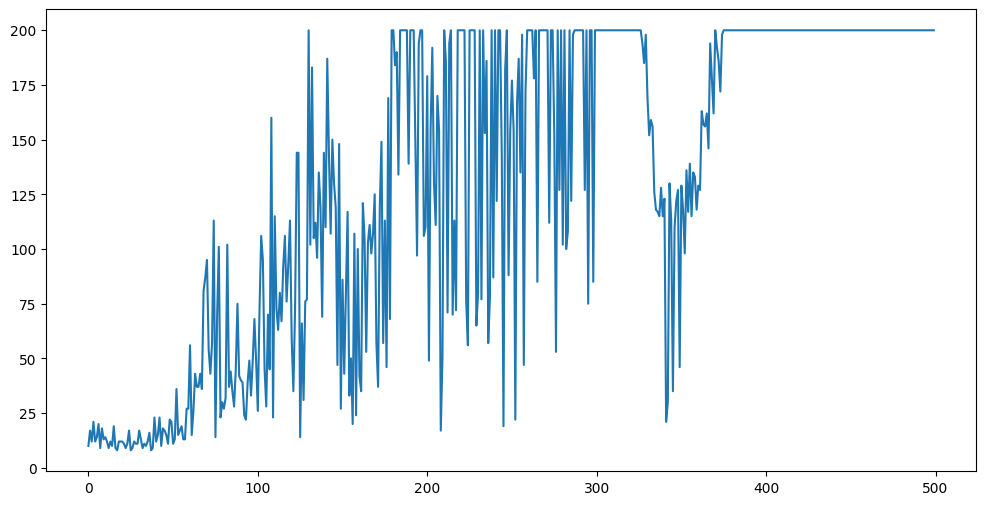

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'score_baseline' and 'score_custom' are lists of episode lengths during training
# For the baseline and custom reward models respectively

# Plotting the training curves
plt.figure(figsize=(12,6))
plt.plot(score_baseline, label='Baseline Model (Original Reward)')
plt.plot(score_custom, label='Custom Reward Model')
plt.xlabel('Trajectory')
plt.ylabel('Episode Length')
plt.title('Training Progress Over Trajectories')
plt.legend()
plt.show()


In [ ]:
%%time

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
HIDDEN_SIZE = 256

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

print (model)

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)
CPU times: user 1.94 ms, sys: 0 ns, total: 1.94 ms
Wall time: 1.8 ms


In [ ]:
%%time

def add_observation(ob_data, trajectory, curr_state, action, reward):
  if trajectory not in observation_data:
      ob_data[trajectory] = []

  temp = list(curr_state)
  temp.append(action)
  temp.append(reward)
  ob_data[trajectory].append(temp)

  return ob_data

learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.99
score = []

observation_data = {}

for trajectory in range(MAX_TRAJECTORIES):

    curr_state = env.reset()
    observation_data = add_observation(observation_data, trajectory, curr_state, 0, 0)

    done = False
    transitions = []

    for t in range(Horizon):
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, reward, done, info = env.step(action)
        #new_r = dumm_func
        transitions.append((prev_state, action, t+1))

        observation_data = add_observation(observation_data, trajectory, curr_state, action, reward)


        if done:
            break
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))

    batch_Gvals =[]
    for i in range(len(transitions)):
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch=torch.FloatTensor(batch_Gvals)


    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions])
    action_batch = torch.Tensor([a for (s,a,r) in transitions])

    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()

    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

Trajectory 50	Average Score: 50.22
Trajectory 100	Average Score: 77.55
Trajectory 150	Average Score: 95.41
Trajectory 200	Average Score: 170.12
Trajectory 250	Average Score: 120.45
Trajectory 300	Average Score: 143.61
Trajectory 350	Average Score: 170.14
Trajectory 400	Average Score: 184.69
Trajectory 450	Average Score: 166.10
CPU times: user 2min 33s, sys: 441 ms, total: 2min 33s
Wall time: 2min 36s
